# Analysis of HDF5 Darshan Logs with PyDarshan

_Last updated: November 2020_

## Darshan

[Darshan](https://www.mcs.anl.gov/research/projects/darshan/) is a diagnostic tool for HPC I/O profiling. It's design makes it applicable for continuous monitoring and not just sporadic I/O performance investigations. Darshan consists of two independent components for generating and analyzing profiling information. The source code and release tarballs are available from https://xgitlab.cels.anl.gov/darshan/darshan. PyDarshan is a Python package for Darshan profiling data analysis and is available from the same repository.

### Darshan Profiling Information

The profiling information includes basic runtime information, mounted file systems, _records_, and _modules_. Records are numeric identifiers representing the storage objects (such as files) for which profiling information is available. Modules represent different types of I/O operations, such as POSIX, MPI-IO, STDIO, etc. Each module has a number of _counters_ that represent various statistical properties of the module's I/O operations.

Complete Darshan documentation is available at https://www.mcs.anl.gov/research/projects/darshan/documentation/ .

### PyDarshan

#### Installation

Darshan analysis software must be built prior to installing PyDarshan. The two steps can be combined with:
```shell
$ cd darshan-util
$ ./configure --prefix=INSTALLDIR --enable-shared --enable-pydarshan PYTHON=/path/to/python3
$ make install
```
PyDarshan will be installed in the `INSTALLDIR/lib/pydarshan` directory. Finally, add these two environment variables:
```shell
$ export PYTHONPATH=INSTALLDIR/lib/pydarshan/lib/python3.8/site-packages
$ export LD_LIBRARY_PATH=INSTALLDIR/lib
```
so PyDarshan, its Python dependencies, and the `libdarshan-util.so` file can be found. Use `DYLD_LIBRARY_PATH` instead of `LD_LIBRARY_PATH` on macOS.

#### Documentation

PyDarshan documentation is for now only available from the [repository](https://xgitlab.cels.anl.gov/darshan/darshan/-/tree/master/darshan-util/pydarshan/docs) in its "source" reStructuredText format. Use the standard Python method to convert it into any of the typical viewable formats.

## HDF5

[HDF5](https://www.hdfgroup.org/solutions/hdf5/) is a data model, library, and file format for storing and managing data. It supports an unlimited variety of datatypes, and is designed for flexible and efficient I/O and for high volume and complex data. The HDF5 Technology suite includes tools and applications for managing, manipulating, viewing, and analyzing data in the HDF5 format.

Darshan provides HDF5-specific profiling data in two modules: [H5F](https://www.mcs.anl.gov/research/projects/darshan/docs/darshan-util.html#idm773) and [H5D](https://www.mcs.anl.gov/research/projects/darshan/docs/darshan-util.html#idm813) when the Darshan profiling tool is built with the ``--enable-hdf5-mod=/path/to/hdf5`` configure option.



## Tutorial

PyDarshan at this time is in its very early stage of the development so its API may change. We are going to clearly indicate here when using any feature that is marked experimental as of now.

### Runtime Environment

Python's version:

In [1]:
from platform import python_version
python_version()

'3.8.6'

Packages and their versions:

In [2]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import darshan

In [3]:
for _ in (pd, darshan):
    print(f'{_.__name__} v{_.__version__}')

pandas v1.1.0
darshan v0.1.0


### Reading Darshan Profiling Information

We are using a Darshan file that includes the two HDF5-specific modules.

In [4]:
rep = darshan.DarshanReport('hdf5_iotest_2x2/admin_hdf5_iotest_id22156_9-3-72146-1340208581795942003_1599163359.darshan')

The Python object representing the Darshan report:

In [5]:
rep

### Displaying Basic Information

Below is the information derived from the default header section:

In [6]:
rep.info(metadata=False)

Filename:       hdf5_iotest_2x2/admin_hdf5_iotest_id22156_9-3-72146-1340208581795942003_1599163359.darshan
Times:          2020-09-03 16:02:26 to 2020-09-03 16:02:38 (Duration 0:00:12)
Executeable:    ./hdf5_iotest run-1.ini
Processes:      4
JobID:          22156
UID:            1000
Modules in Log: ['POSIX', 'MPI-IO', 'H5F', 'H5D', 'STDIO']
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'H5F': 1, 'H5D': 1359, 'STDIO': 3}
Name Records:   803
Darshan/Hints:  {'lib_ver': '3.2.1', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
DarshanReport:  id(4382147536) (tmp)


Note the lines in the above report: _Modules in Log_ and _Loaded Records_. The first line reports on all modules present in the Darshan file, while the second line reports only the modules which data are read in.

Setting `metadata=True` adds more metadata information to display:

In [7]:
rep.info(metadata=True)

Filename:       hdf5_iotest_2x2/admin_hdf5_iotest_id22156_9-3-72146-1340208581795942003_1599163359.darshan
Times:          2020-09-03 16:02:26 to 2020-09-03 16:02:38 (Duration 0:00:12)
Executeable:    ./hdf5_iotest run-1.ini
Processes:      4
JobID:          22156
UID:            1000
Modules in Log: ['POSIX', 'MPI-IO', 'H5F', 'H5D', 'STDIO']
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'H5F': 1, 'H5D': 1359, 'STDIO': 3}
Name Records:   803
Darshan/Hints:  {'lib_ver': '3.2.1', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
DarshanReport:  id(4382147536) (tmp)
metadata['job']['uid'] = 1000
metadata['job']['start_time'] = 1599163346
metadata['job']['end_time'] = 1599163358
metadata['job']['nprocs'] = 4
metadata['job']['jobid'] = 22156
metadata['job']['metadata'] = {'lib_ver': '3.2.1', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
metadata['exe'] = ./hdf5_iotest run-1.ini


The "metadata" part is also available separately as a dictionary:

In [8]:
pprint(rep.metadata)

{'exe': './hdf5_iotest run-1.ini',
 'job': {'end_time': 1599163358,
         'jobid': 22156,
         'metadata': {'h': 'romio_no_indep_rw=true;cb_nodes=4',
                      'lib_ver': '3.2.1'},
         'nprocs': 4,
         'start_time': 1599163346,
         'uid': 1000}}


Darshan report's file name:

In [9]:
rep.filename

'hdf5_iotest_2x2/admin_hdf5_iotest_id22156_9-3-72146-1340208581795942003_1599163359.darshan'

Start and end time of the profiling job are available as `datetime.datetime` objects but without a time zone specified:

In [10]:
rep.start_time

datetime.datetime(2020, 9, 3, 16, 2, 26)

In [11]:
rep.end_time

datetime.datetime(2020, 9, 3, 16, 2, 38)

In [12]:
rep.start_time.tzinfo is None

True

### Darshan Modules, Records, Counters

Available modules and their basic information are available as a dictionary of dictionaries:

In [13]:
rep.modules

{'POSIX': {'len': 270, 'ver': 4, 'idx': 1, 'num_records': 1},
 'MPI-IO': {'len': 212, 'ver': 3, 'idx': 2, 'num_records': 1},
 'H5F': {'len': 50, 'ver': 3, 'idx': 3, 'num_records': 1},
 'H5D': {'len': 91756, 'ver': 1, 'idx': 4, 'num_records': 1359},
 'STDIO': {'len': 174, 'ver': 2, 'idx': 8, 'num_records': 3}}

The mounted file systems and their types are available as a list of two-item tuples:

In [14]:
rep.mounts

[('/proc/sys/fs/binfmt_misc', 'autofs'),
 ('/sys/fs/cgroup/unified', 'cgroup2'),
 ('/sys/fs/pstore', 'pstore'),
 ('/mnt/scratch', 'ext4'),
 ('/sys/fs/bpf', 'bpf'),
 ('/dev/mqueue', 'mqueue'),
 ('/boot/efi', 'vfat'),
 ('/dev', 'devtmpfs'),
 ('/', 'ext4')]

Record IDs and their full file name paths are available as a dictionary:

In [15]:
rep.name_records

59226111675751: '/mnt/scratch/out-1.h5:/step=0/array=490',
 5075477941040549916: '/mnt/scratch/out-1.h5:/step=0/array=491',
 2656080831511421580: '/mnt/scratch/out-1.h5:/step=0/array=492',
 981813292813725046: '/mnt/scratch/out-1.h5:/step=0/array=493',
 7088267117835563390: '/mnt/scratch/out-1.h5:/step=0/array=494',
 9797097948874073156: '/mnt/scratch/out-1.h5:/step=0/array=495',
 2470883244632348843: '/mnt/scratch/out-1.h5:/step=0/array=496',
 5946348691341731964: '/mnt/scratch/out-1.h5:/step=0/array=497',
 14802219618710625791: '/mnt/scratch/out-1.h5:/step=0/array=498',
 17606145139435315027: '/mnt/scratch/out-1.h5:/step=0/array=499',
 561704199900244003: '/mnt/scratch/out-1.h5:/step=1/array=0',
 12109967703595006251: '/mnt/scratch/out-1.h5:/step=1/array=1',
 17085615950698936687: '/mnt/scratch/out-1.h5:/step=1/array=2',
 11597017616278610449: '/mnt/scratch/out-1.h5:/step=1/array=3',
 462746467154257129: '/mnt/scratch/out-1.h5:/step=1/array=4',
 11381211498974871650: '/mnt/scratch/ou

In case of HDF5, such records also include HDF5 dataset path names, like below:

In [16]:
rep.name_records[4213945677347829095]

'/mnt/scratch/out-1.h5:/step=1/array=296'

The above record name has two parts:

1. the full file path, `/mnt/scratch/out-1.h5`, and
1. the path name of one of the HDF5 datasets in the file, `/step=1/array=296`.

All the counters present in the Darshan file are available as a dictionary from the `.counters` property. They are organized per their modules:

In [17]:
rep.counters.keys()

dict_keys(['POSIX', 'MPI-IO', 'H5F', 'H5D', 'STDIO'])

The counters for each module are further separated into _integer_ and _floating-point_ groups:

In [18]:
rep.counters['H5F'].keys()

dict_keys(['counters', 'fcounters'])

For example, integer counters for the H5F module are:

In [19]:
rep.counters['H5F']['counters']

['H5F_OPENS', 'H5F_FLUSHES', 'H5F_USE_MPIIO']

and H5F's floating-point counters are:

In [20]:
rep.counters['H5F']['fcounters']

['H5F_F_OPEN_START_TIMESTAMP',
 'H5F_F_CLOSE_START_TIMESTAMP',
 'H5F_F_OPEN_END_TIMESTAMP',
 'H5F_F_CLOSE_END_TIMESTAMP',
 'H5F_F_META_TIME']

H5D module counters are:

In [21]:
pprint(rep.counters['H5D'])

{'counters': ['H5D_OPENS',
              'H5D_READS',
              'H5D_WRITES',
              'H5D_FLUSHES',
              'H5D_BYTES_READ',
              'H5D_BYTES_WRITTEN',
              'H5D_RW_SWITCHES',
              'H5D_REGULAR_HYPERSLAB_SELECTS',
              'H5D_IRREGULAR_HYPERSLAB_SELECTS',
              'H5D_POINT_SELECTS',
              'H5D_MAX_READ_TIME_SIZE',
              'H5D_MAX_WRITE_TIME_SIZE',
              'H5D_SIZE_READ_AGG_0_100',
              'H5D_SIZE_READ_AGG_100_1K',
              'H5D_SIZE_READ_AGG_1K_10K',
              'H5D_SIZE_READ_AGG_10K_100K',
              'H5D_SIZE_READ_AGG_100K_1M',
              'H5D_SIZE_READ_AGG_1M_4M',
              'H5D_SIZE_READ_AGG_4M_10M',
              'H5D_SIZE_READ_AGG_10M_100M',
              'H5D_SIZE_READ_AGG_100M_1G',
              'H5D_SIZE_READ_AGG_1G_PLUS',
              'H5D_SIZE_WRITE_AGG_0_100',
              'H5D_SIZE_WRITE_AGG_100_1K',
              'H5D_SIZE_WRITE_AGG_1K_10K',
              'H5D_SIZE_

### Plotting Profiling Data

Plotting in PyDarshan is currently marked as an experimental feature and must be first enabled and then the plotting functions can be imported from their experimental module:

In [22]:
darshan.enable_experimental()
from darshan.experimental.plots.matplotlib import plot_access_histogram, plot_opcounts

Below are the kinds of plots that do work for our Darshan file with HDF5-specific profiling information. It is important to note that the plots presented here may or may not work for every Darshan report as they are dependent on what profiling data are available in the actual file.

Summarizing... iohist POSIX


<module 'matplotlib.pyplot' from '/Users/ajelenak/Documents/Darshan/darshan-master/build/util/lib/pydarshan/lib/python3.8/site-packages/matplotlib-3.3.0-py3.8-macosx-10.13-x86_64.egg/matplotlib/pyplot.py'>

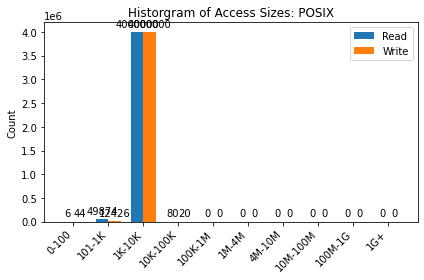

In [23]:
plot_access_histogram(rep, 'POSIX')

Summarizing... iohist MPI-IO


<module 'matplotlib.pyplot' from '/Users/ajelenak/Documents/Darshan/darshan-master/build/util/lib/pydarshan/lib/python3.8/site-packages/matplotlib-3.3.0-py3.8-macosx-10.13-x86_64.egg/matplotlib/pyplot.py'>

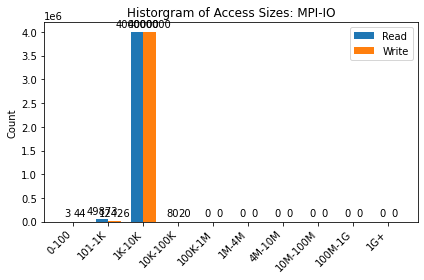

In [24]:
plot_access_histogram(rep, 'MPI-IO')

Summarizing... agg_ioops
Read,Write,Open,Stat,Seek,Mmap,Fsync,Layer
4049960,4012490,10,2,6,0,0,POSIX
4049956,4012490,0,0,0,0,0,MPIIND
0,0,8,0,0,0,0,MPICOL
31,14,3,0,0,0,0,STDIO



<module 'matplotlib.pyplot' from '/Users/ajelenak/Documents/Darshan/darshan-master/build/util/lib/pydarshan/lib/python3.8/site-packages/matplotlib-3.3.0-py3.8-macosx-10.13-x86_64.egg/matplotlib/pyplot.py'>

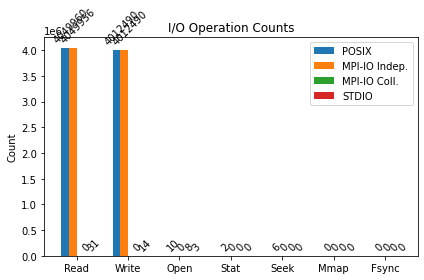

In [25]:
plot_opcounts(rep)

### Working with HDF5-Specific Profiling Data

PyDarshan currently does not support HDF5-specific modules so below is a function to reformat Darshan non-DXT module data to a pandas.DataFrame.

In [26]:
def module2df(rep: darshan.DarshanReport, module: str) -> pd.DataFrame:
    """Convert Darshan module log to pandas DataFrame.
    """
    mod_df = pd.DataFrame()
    for e in rep.records[module]:
        df1 = pd.DataFrame({'counter': rep.counters[module]['counters'],
                            'value': e['counters']})
        df2 = pd.DataFrame({'counter': rep.counters[module]['fcounters'], 
                            'value': e['fcounters']})
        df1 = pd.concat([df1, df2], axis=0, ignore_index=True)
        df1 = df1.assign(rank=e['rank'], record=rep.name_records[e['id']])
        mod_df = pd.concat([mod_df, df1], axis=0, ignore_index=True)

    return mod_df

Converting the H5F module data to a pandas.Dataframe gives:

In [27]:
h5f = module2df(rep, 'H5F')
h5f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   counter  8 non-null      object 
 1   value    8 non-null      float64
 2   rank     8 non-null      int64  
 3   record   8 non-null      object 
dtypes: float64(1), int64(1), object(2)
memory usage: 384.0+ bytes


In [28]:
h5f

,counter,value,rank,record
0,H5F_OPENS,9.000000,-1,/mnt/scratch/out-1.h5
1,H5F_FLUSHES,0.000000,-1,/mnt/scratch/out-1.h5
2,H5F_USE_MPIIO,1.000000,-1,/mnt/scratch/out-1.h5
3,H5F_F_OPEN_START_TIMESTAMP,0.001401,-1,/mnt/scratch/out-1.h5
4,H5F_F_CLOSE_START_TIMESTAMP,9.218065,-1,/mnt/scratch/out-1.h5
5,H5F_F_OPEN_END_TIMESTAMP,11.637774,-1,/mnt/scratch/out-1.h5
6,H5F_F_CLOSE_END_TIMESTAMP,11.637802,-1,/mnt/scratch/out-1.h5
7,H5F_F_META_TIME,0.315327,-1,/mnt/scratch/out-1.h5


There is not much data above since only one HDF5 file was involved. Still, it is possible to illustrate how to extract useful information in case (many) more HDF5 files were present.

For example, list of all HDF5 files:

In [29]:
h5f['record'].unique()

array(['/mnt/scratch/out-1.h5'], dtype=object)

Grouping H5F module data by the counter enables per-file analysis of all their data:

In [30]:
h5f_grp = h5f.groupby('counter')

The largest number of HDF5 file open operations:

In [31]:
h5f_grp.get_group('H5F_OPENS').max()

counter                H5F_OPENS
value                          9
rank                          -1
record     /mnt/scratch/out-1.h5
dtype: object

Top 5 HDF5 files with the longest cumulative times spent in open, close, or flush operations:

In [32]:
h5f_grp.get_group('H5F_F_META_TIME').nlargest(5, 'value', keep='all')

,counter,value,rank,record
7,H5F_F_META_TIME,0.315327,-1,/mnt/scratch/out-1.h5


Reformatting the H5D module data to a pandas.DataFrame yields:

In [33]:
h5d = module2df(rep, 'H5D')
h5d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150849 entries, 0 to 150848
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   counter  150849 non-null  object 
 1   value    150849 non-null  float64
 2   rank     150849 non-null  int64  
 3   record   150849 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


This DataFrame has many more rows so let's show just the first 10:

In [34]:
h5d.head(10)

,counter,value,rank,record
0,H5D_OPENS,8.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
1,H5D_READS,4.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
2,H5D_WRITES,4.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
3,H5D_FLUSHES,0.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
4,H5D_BYTES_READ,640000.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
5,H5D_BYTES_WRITTEN,640000.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
6,H5D_RW_SWITCHES,4.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
7,H5D_REGULAR_HYPERSLAB_SELECTS,8.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
8,H5D_IRREGULAR_HYPERSLAB_SELECTS,0.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409
9,H5D_POINT_SELECTS,0.0,-1,/mnt/scratch/out-1.h5:/step=0/array=409


The number of records in this module are:

In [35]:
h5d['record'].unique().size

797

H5D module records are HDF5 datasets. Let's show the last 5:

In [36]:
h5d['record'].unique()[-5:]

array(['/mnt/scratch/out-1.h5:/step=1/array=68',
       '/mnt/scratch/out-1.h5:/step=1/array=62',
       '/mnt/scratch/out-1.h5:/step=1/array=24',
       '/mnt/scratch/out-1.h5:/step=1/array=261',
       '/mnt/scratch/out-1.h5:/step=1/array=20'], dtype=object)

Grouping on counters:

In [37]:
h5d_grp = h5d.groupby('counter')

we can start looking at I/O statistics across all HDF5 datasets or broken down per each dataset. For example, descriptive stats for slowest H5D read operations:

In [38]:
h5d_grp.get_group('H5D_MAX_READ_TIME_SIZE')['value'].describe()

count      1359.0
mean     160000.0
std           0.0
min      160000.0
25%      160000.0
50%      160000.0
75%      160000.0
max      160000.0
Name: value, dtype: float64

Descriptive stats about the total number of bytes written to all HDF5 dataset:

In [39]:
h5d_grp.get_group('H5D_BYTES_WRITTEN')['value'].describe()

count      1359.000000
mean     342251.655629
std      233034.521727
min      160000.000000
25%      160000.000000
50%      160000.000000
75%      640000.000000
max      640000.000000
Name: value, dtype: float64

The 10 smallest cumulative dataset read times:

In [40]:
h5d_grp.get_group('H5D_F_READ_TIME').nsmallest(10, 'value')

,counter,value,rank,record
150285,H5D_F_READ_TIME,0.000179,3,/mnt/scratch/out-1.h5:/step=1/array=272
120648,H5D_F_READ_TIME,0.000179,3,/mnt/scratch/out-1.h5:/step=1/array=108
141072,H5D_F_READ_TIME,0.000179,3,/mnt/scratch/out-1.h5:/step=1/array=252
130083,H5D_F_READ_TIME,0.000179,3,/mnt/scratch/out-1.h5:/step=1/array=213
147843,H5D_F_READ_TIME,0.000179,3,/mnt/scratch/out-1.h5:/step=1/array=244
143514,H5D_F_READ_TIME,0.000179,3,/mnt/scratch/out-1.h5:/step=1/array=282
120870,H5D_F_READ_TIME,0.000180,3,/mnt/scratch/out-1.h5:/step=1/array=33
134079,H5D_F_READ_TIME,0.000180,3,/mnt/scratch/out-1.h5:/step=1/array=151
127752,H5D_F_READ_TIME,0.000180,3,/mnt/scratch/out-1.h5:/step=1/array=287
132303,H5D_F_READ_TIME,0.000180,3,/mnt/scratch/out-1.h5:/step=1/array=31


Total number of bytes read from and written to each record (HDF5 dataset):

In [41]:
h5d_grp.get_group('H5D_BYTES_READ').groupby('record')['value'].sum()

record
/mnt/scratch/out-1.h5:/step=0/array=0      640000.0
/mnt/scratch/out-1.h5:/step=0/array=1      640000.0
/mnt/scratch/out-1.h5:/step=0/array=10     640000.0
/mnt/scratch/out-1.h5:/step=0/array=100    640000.0
/mnt/scratch/out-1.h5:/step=0/array=101    640000.0
                                             ...   
/mnt/scratch/out-1.h5:/step=1/array=95     480000.0
/mnt/scratch/out-1.h5:/step=1/array=96     480000.0
/mnt/scratch/out-1.h5:/step=1/array=97     480000.0
/mnt/scratch/out-1.h5:/step=1/array=98     480000.0
/mnt/scratch/out-1.h5:/step=1/array=99     480000.0
Name: value, Length: 797, dtype: float64

In [42]:
h5d_grp.get_group('H5D_BYTES_WRITTEN').groupby('record')['value'].sum()

record
/mnt/scratch/out-1.h5:/step=0/array=0      640000.0
/mnt/scratch/out-1.h5:/step=0/array=1      640000.0
/mnt/scratch/out-1.h5:/step=0/array=10     640000.0
/mnt/scratch/out-1.h5:/step=0/array=100    640000.0
/mnt/scratch/out-1.h5:/step=0/array=101    640000.0
                                             ...   
/mnt/scratch/out-1.h5:/step=1/array=95     480000.0
/mnt/scratch/out-1.h5:/step=1/array=96     480000.0
/mnt/scratch/out-1.h5:/step=1/array=97     480000.0
/mnt/scratch/out-1.h5:/step=1/array=98     480000.0
/mnt/scratch/out-1.h5:/step=1/array=99     480000.0
Name: value, Length: 797, dtype: float64

### Plotting HDF5 Profiling Data

PyDarshan currently does not support plotting HDF5-related module data. Below is an example function, modeled on PyDarshan's `plot_access_histogram()` function, for plotting total H5D read/write access size histograms. It shows how H5D module data as a pandas DataFrame can be utilized as easily for both analysis and plotting.

In [43]:
def plot_h5d_access_histogram(grpby: pd.core.groupby.DataFrameGroupBy) -> None:
    ranges = ['0_100', '100_1K', '1K_10K', '10K_100K', '100K_1M', '1M_4M', 
              '4M_10M', '10M_100M', '100M_1G', '1G_PLUS']
    labels = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K-1M', '1M-4M', 
              '4M-10M', '10M-100M', '100M-1G', '1G+']
    read_vals = [h5d_grp.get_group('H5D_SIZE_READ_AGG_' + rng)['value'].sum() 
                 for rng in ranges]
    write_vals = [h5d_grp.get_group('H5D_SIZE_WRITE_AGG_' + rng)['value'].sum() 
                 for rng in ranges]
    
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, read_vals, width, label='Read')
    rects2 = ax.bar(x + width/2, write_vals, width, label='Write')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title('Historgram of H5D Access Sizes')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=0)

    autolabel(rects1)
    autolabel(rects2)

    return plt

<module 'matplotlib.pyplot' from '/Users/ajelenak/Documents/Darshan/darshan-master/build/util/lib/pydarshan/lib/python3.8/site-packages/matplotlib-3.3.0-py3.8-macosx-10.13-x86_64.egg/matplotlib/pyplot.py'>

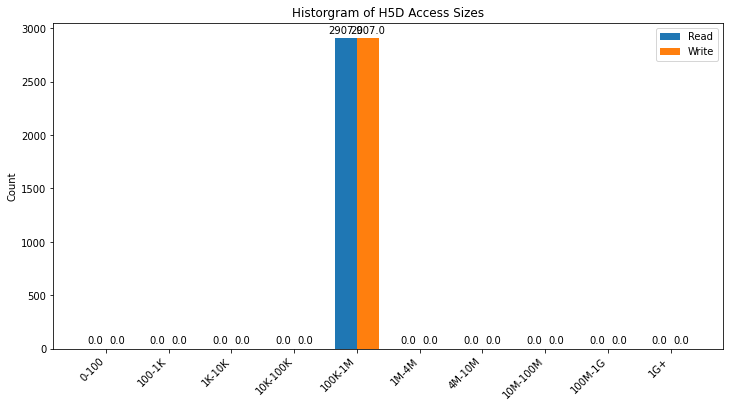

In [44]:
plot_h5d_access_histogram(h5d_grp)

### The End